# DeepONet with `PyTorch`

- https://github.com/JohnCSu/DeepONet_Pytorch_Demo
- https://johncsu.github.io/DeepONet_Demo/

In [ ]:
import torch.nn as nn
import torch
import numpy as np

from matplotlib import pyplot as plt
from torch.optim import Adam

# DeepONet

Solve the following 1D ODE problem:
$$
\frac{d}{dx}F(x) = g(x) \\
F(0) = 0\\
\text{for} \  x \in [0,2]
$$

Here $g(x)$ is given.

## Network

The network $G(u)(y)$ takes in two inputs: y and u. 
- 'u' represents the $g(x)$ in our problem.
- 'y' represents the points we want to query.

We need 2 'batch' dimensions to loop over - one to handle the trunk net and one for the branch net. 

- branch net $u(x)$ has shape [B,1,M]
- trunk net input has shape [B,N,I]
- Output of Onet shape [B,N,O]

Where:
- B is the batch dimension for the branch net
- N is the 'batch' dimension for the trunk net
- M is the number of sensors that discretize u(x)/input dimension of the branch net
- I is the input dimension of the trunk net
- O is the output dimension size of the Onet

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features : int, out_features: int, hidden_features: int, num_hidden_layers: int) -> None:
        super().__init__()

        
        self.linear_in = nn.Linear(in_features,hidden_features)
        self.linear_out = nn.Linear(hidden_features,out_features)
        
        self.activation = torch.tanh
        self.layers = nn.ModuleList([self.linear_in] + [nn.Linear(hidden_features, hidden_features) for _ in range(num_hidden_layers)  ])
        
         
    def forward(self,x):
        for layer in self.layers:
            x = self.activation(layer(x))
    
        return self.linear_out(x)


class DeepONet(nn.Module):
    def __init__(self, latent_features, out_features, branch, trunk) -> None:
        super().__init__()
        self.branch = branch
        self.trunk = trunk
        self.fc = nn.Linear(latent_features, out_features, bias = False)
        

    def forward(self,y,u):
        return self.fc(self.trunk(y)*self.branch(u))

In [ ]:
Onet = DeepONet(75, 1, branch = MLP(100,75,75,4), trunk = MLP(1,75,75,4))

u = torch.rand((2, 1, 100))
y = torch.rand((2, 40, 1))

xx = Onet.trunk(y)
tt = Onet.branch(u)

Onet(y,u).shape

torch.Size([2, 40, 1])

# Generating Data

Gnerate 10000 derivatives $u(x)$ using Chebyshev polynomials. 

For the derivative $u(x)$ we discretize using 100 uniformly spaced points. 

For $G(u)(y)$ we randomly sample 100 points in the domain

The tuple of data of the shape (y,u,Guy) where:
- y is the sampling points of shape $[10000,100,1]$
- u is the discretized derivative function of shape $[10000,1,100]$
- $G(u)(y)$ is target output of the Onet os shape $[10000,100,1]$

In [ ]:
from numpy.polynomial.chebyshev import Chebyshev,chebval,chebint,cheb2poly
def random_chebyshev(n,M,degree,return_coeff = False):
    '''
    This generates a random function output between the domain [-1,1] along a uniform grid of size n using chebyshev polynomials.
    '''
    coeff = (np.random.rand(degree+1)-0.5)*2*np.abs(M)
    x= np.linspace(-1,1,n)
    y = chebval(x,coeff)
    if return_coeff:
        return x,y,coeff
    else:
        return x,y

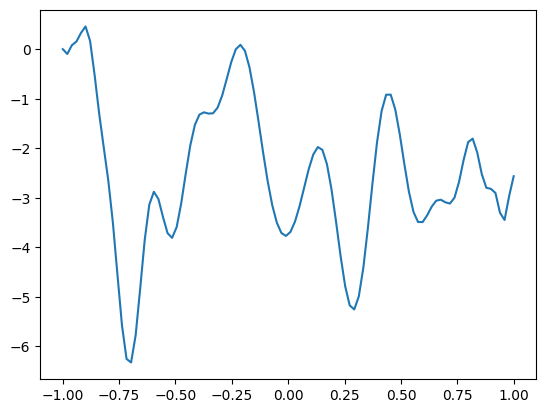

In [ ]:
from scipy.integrate import cumulative_trapezoid
x,y,coeff = random_chebyshev(100,10,30,return_coeff= True)

y_int = cumulative_trapezoid(y,x,initial = 0)

plt.plot(x,y_int);

In [ ]:
# Generate DataTuples:
def generate_data(n_samples,a,b,n_sensors,n_points,M,degree,y0 = 0,random_query = False,seed = 1234):
    '''
    Generate Data needed for training.

    Returns a tuple of (y,u,Guy) that will be added to the Dataloader
    '''
    if seed is not None:
        np.random.seed(1234)
    
    x = np.linspace(-1,1,n_points)
    u,dy_coeff = zip(*[random_chebyshev(n_sensors,M,degree,return_coeff=True)[1:] for _ in range(n_samples)])

    u = np.stack(u,axis = 0)

    #Generate 100 y points for [a,b]
    xp = np.linspace(a,b,n_sensors)
    if random_query:
        y = np.random.rand(n_samples,n_points)*(b-a)+a
    else:
        # y = np.array([np.linspace(a,b,n_points) for _ in range(n_samples)]
        y = np.tile(np.linspace(a,b,n_points),(n_samples,1))

    #Integrate cheb poly, we use interp in case we want random y points
    Guy = [cumulative_trapezoid(dy,xp,initial=y0) for dy in u]
    Guy = [np.interp(yy,xp,G) for yy,G in zip(y,Guy)]

    #Guy data needs 2 batch dimensions: One for samples and the other for  
    y = torch.from_numpy(np.asarray(y, dtype=np.float32))
    u = torch.from_numpy(np.asarray(u, dtype=np.float32))
    Guy = torch.from_numpy(np.asarray(Guy, dtype=np.float32))
    #To match network shape input and output, need to add a tensor dimension to y and Guy
    return y.unsqueeze(-1),u.unsqueeze(1),Guy.unsqueeze(-1)

In [ ]:
ys,us,Guys = generate_data(10000,0,2,100,100,5,20)
ys.shape,us.shape,Guys.shape

(torch.Size([10000, 100, 1]),
 torch.Size([10000, 1, 100]),
 torch.Size([10000, 100, 1]))

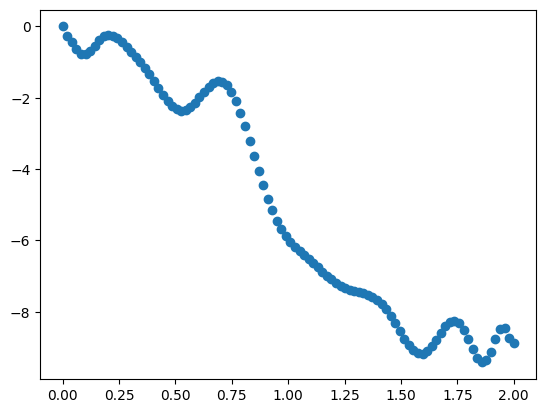

In [ ]:
plt.scatter(ys[2].squeeze(),Guys[2].squeeze());

# Training Pipeline

In [ ]:
from torch.utils.data import DataLoader,Dataset

In [ ]:
class Onet_dataset(Dataset):
    def __init__(self,y,u,Guy):
        self.y = y
        self.u = u
        self.Guy = Guy
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.y[idx],self.u[idx],self.Guy[idx]

In [ ]:
ys,us,Guys = generate_data(10000,0,2,100,90,5,20)
Onet_data = Onet_dataset(ys,us,Guys)
Onet_DL = DataLoader(Onet_data,batch_size = 1000,shuffle = True)

Onet = DeepONet(75,1,branch = MLP(100,75,75,4),trunk = MLP(1,75,75,4))

optimiser = Adam(Onet.parameters(),lr = 5e-4)
lr_sch = torch.optim.lr_scheduler.StepLR(optimiser,1000,0.95)

In [ ]:
Onet = Onet.cuda()
optimiser.zero_grad()
x = torch.linspace(0,2,100)
a = 4
dy = torch.sin(a*x)

dy_in = dy.unsqueeze(0).unsqueeze(1)
x_in = x.unsqueeze(0).unsqueeze(-1)
out_true = -1/a*(torch.cos(a*x)-1)
print(dy_in.shape,x_in.shape)

loss_list = []
acc_list = []
for epoch in range(0,7501):
    for (y,u,Guy) in(Onet_DL):
        (y,u,Guy) = (y.cuda(),u.cuda(),Guy.cuda())
        # print(y.shape,u.shape,Guy.shape)
        out = Onet(y,u)
        # print(out.shape,Guy.shape)
        loss = (out-Guy).pow(2).mean()
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        lr_sch.step()
    if (epoch % 100) == 0:
        print(f'{float(lr_sch.get_last_lr()[0]):.3E}')
        with torch.no_grad():
            out = Onet.cpu()(x_in,dy_in).squeeze()
            accuracy = (out-out_true).pow(2).mean()
            Onet = Onet.cuda()
        
        print(f'Epoch: {epoch} loss {float(loss):.3e} Acc {float(accuracy):.3e}')
        loss_list.append(float(loss))
        acc_list.append(float(accuracy))

torch.Size([1, 1, 100]) torch.Size([1, 100, 1])
5.000E-04
Epoch: 0 loss 1.505e+01 Acc 6.066e-02
4.750E-04
Epoch: 100 loss 5.852e-01 Acc 5.080e-01
4.512E-04
Epoch: 200 loss 3.024e-01 Acc 1.198e-02
4.287E-04
Epoch: 300 loss 1.915e-01 Acc 1.925e-03
4.073E-04
Epoch: 400 loss 1.432e-01 Acc 7.838e-04
3.869E-04
Epoch: 500 loss 1.177e-01 Acc 6.942e-04
3.675E-04
Epoch: 600 loss 1.023e-01 Acc 4.080e-04
3.492E-04
Epoch: 700 loss 7.825e-02 Acc 4.164e-04
3.317E-04
Epoch: 800 loss 6.121e-02 Acc 3.095e-04
3.151E-04
Epoch: 900 loss 5.791e-02 Acc 3.097e-04
2.994E-04
Epoch: 1000 loss 4.661e-02 Acc 4.209e-04
2.844E-04
Epoch: 1100 loss 4.288e-02 Acc 1.948e-04
2.702E-04
Epoch: 1200 loss 3.725e-02 Acc 2.725e-04
2.567E-04
Epoch: 1300 loss 3.063e-02 Acc 1.757e-04
2.438E-04
Epoch: 1400 loss 3.178e-02 Acc 1.800e-04
2.316E-04
Epoch: 1500 loss 2.312e-02 Acc 1.765e-04
2.201E-04
Epoch: 1600 loss 1.971e-02 Acc 8.998e-05
2.091E-04
Epoch: 1700 loss 1.846e-02 Acc 6.651e-05
1.986E-04
Epoch: 1800 loss 1.975e-02 Acc 3.155

torch.Size([100])


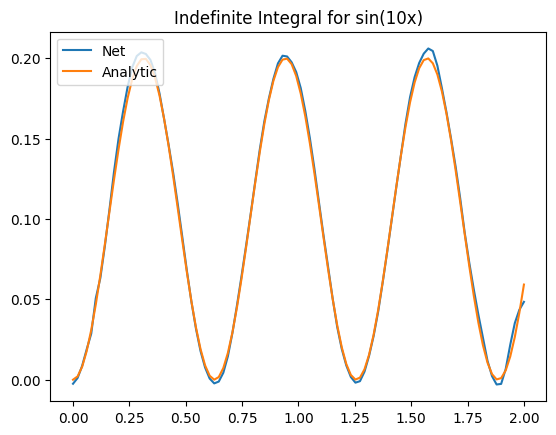

In [ ]:
a = 10

x = torch.linspace(0,2,100)
dy = torch.sin(a*x)
dy_in = dy.unsqueeze(0).unsqueeze(1)
x_in = x.unsqueeze(0).unsqueeze(-1)
out_true = -1/a*(torch.cos(a*x)-1)
-(torch.cos(a*x)-1)
with torch.no_grad():
    out = Onet.cpu()(x_in,dy_in).squeeze()

print(out.shape)

plt.plot(x,out,label = 'Net')
plt.plot(x,out_true,label = 'Analytic')
plt.legend(loc='upper left')
plt.title(f'Indefinite Integral for sin({a}x)')
plt.savefig(f'a_{a}.png')
plt.show()

# Physics-informed DeepONet

To take derivatives efficiently, we use the `torch.func` library a jax like library designed for pytorch.

In [ ]:
from torch.func import vmap,jacrev,grad

In [ ]:
def batched_PINO_grad(net):
    def aux_net(net):
        def inner_func(*args,**kwargs):
            out = net(*args,**kwargs)
            return out,out
        return inner_func
    
    g = jacrev(aux_net(net),has_aux=True)
    # If y,u are the arg inputs, we only want to iterate over y's first dim (the query dim) not u

    grad_func = vmap(g,(0,None))

    return vmap(grad_func,0)

In [ ]:
PINO = DeepONet(75,1,branch = MLP(100,75,75,4),trunk = MLP(1,75,75,4))

f = batched_PINO_grad(PINO)
y = torch.rand((5,100,1))
u = torch.rand((5,1,100))

grads,evals = f(y,u)
grads.shape,evals.shape,PINO(y,u).shape

(torch.Size([5, 100, 1, 1, 1]),
 torch.Size([5, 100, 1, 1]),
 torch.Size([5, 100, 1]))

In [ ]:
ys,us,Guys = generate_data(10000,0,2,100,100,5,20)
Pino_data = Onet_dataset(ys,us,Guys)
# Onet_data.set_device('cuda')
Pino_DL = DataLoader(Pino_data,batch_size = 1000,shuffle = True)


optimiser = Adam(PINO.parameters())
lr_sch = torch.optim.lr_scheduler.StepLR(optimiser,1000,0.95)

In [ ]:
evals[:,0].squeeze()

tensor([0.0046, 0.0052, 0.0060, 0.0057, 0.0050], grad_fn=<SqueezeBackward0>)

In [ ]:
PINO = PINO.cuda()
optimiser.zero_grad()
x = torch.linspace(0,2,100)
a = 4
dy = torch.sin(a*x)

dy_in = dy.unsqueeze(0).unsqueeze(1)
x_in = x.unsqueeze(0).unsqueeze(-1)
out_true = -1/a*(torch.cos(a*x)-1)
print(dy_in.shape,x_in.shape)

PINO_loss_list= []
PINO_acc_list = []
f = batched_PINO_grad(PINO)
for epoch in range(0,7501):
    for (y,u,Guy) in(Pino_DL):
        (y,u,Guy) = (y.cuda(),u.cuda(),Guy.cuda())
        # print(y.shape,u.shape,Guy.shape)
        grads,evals = f(y,u)

        #PINN loss
        
        PINN_loss = (grads.squeeze() - u.squeeze()).pow(2).mean()
        
        #Initial Condition Loss
        IC_loss = (evals[:,0].squeeze()).pow(2).mean()

        # print(out.shape,Guy.shape)
        # loss = (out-Guy).pow(2).mean()
        loss = 10*PINN_loss + IC_loss
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        lr_sch.step()
    if (epoch % 100) == 0:
        print(f'{float(lr_sch.get_last_lr()[0]):.3E}')
        with torch.no_grad():
            out = PINO.cpu()(x_in,dy_in).squeeze()
            accuracy = (out-out_true).pow(2).mean()
            PINO = PINO.cuda()
        
        print(f'Epoch: {epoch} loss {float(loss):.3e} PINN Loss {float(PINN_loss):.3e} IC Loss {float(IC_loss):.3e} Acc {float(accuracy):.3e}')
        PINO_loss_list.append(float(loss))
        PINO_acc_list.append(float(accuracy))

torch.Size([1, 1, 100]) torch.Size([1, 100, 1])
1.000E-03
Epoch: 0 loss 8.880e+02 PINN Loss 8.879e+01 IC Loss 5.612e-02 Acc 8.595e-02
9.500E-04
Epoch: 100 loss 7.601e+01 PINN Loss 7.428e+00 IC Loss 1.734e+00 Acc 4.299e-03
9.025E-04
Epoch: 200 loss 2.394e+01 PINN Loss 2.393e+00 IC Loss 7.206e-03 Acc 3.287e-03
8.574E-04
Epoch: 300 loss 6.898e+00 PINN Loss 6.892e-01 IC Loss 5.344e-03 Acc 3.906e-03
8.145E-04
Epoch: 400 loss 2.436e+01 PINN Loss 2.435e+00 IC Loss 1.350e-02 Acc 1.808e-03
7.738E-04
Epoch: 500 loss 1.899e+00 PINN Loss 1.899e-01 IC Loss 1.205e-04 Acc 7.418e-04
7.351E-04
Epoch: 600 loss 1.008e+00 PINN Loss 1.008e-01 IC Loss 2.262e-04 Acc 9.848e-04
6.983E-04
Epoch: 700 loss 1.182e+00 PINN Loss 1.182e-01 IC Loss 1.494e-04 Acc 8.071e-04
6.634E-04
Epoch: 800 loss 7.988e-01 PINN Loss 7.987e-02 IC Loss 3.039e-05 Acc 2.678e-03
6.302E-04
Epoch: 900 loss 6.608e-01 PINN Loss 6.608e-02 IC Loss 1.793e-05 Acc 5.132e-04
5.987E-04
Epoch: 1000 loss 5.818e-01 PINN Loss 5.818e-02 IC Loss 3.157e-05

torch.Size([100])


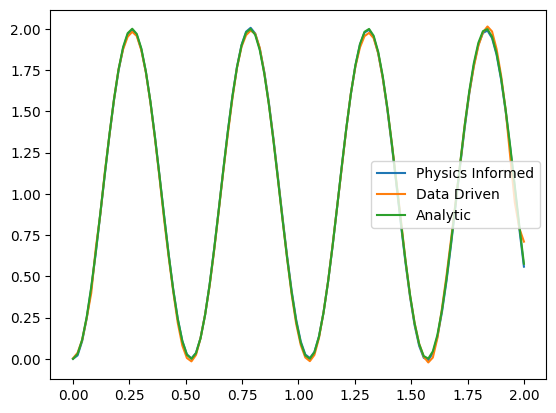

In [ ]:
x = torch.linspace(0,2,100)
a = 12
dy = a*torch.sin(a*x)

dy_in = dy.unsqueeze(0).unsqueeze(1)
x_in = x.unsqueeze(0).unsqueeze(-1)
out_true = -1/a*(torch.cos(a*x)-1)
with torch.no_grad():
    out = PINO.cpu()(x_in,dy_in).squeeze()
    out_dd = Onet.cpu()(x_in,dy_in).squeeze()
print(out.shape)
# out = torch.tensor(out).squeeze()
plt.plot(x,out,label = 'Physics Informed')
plt.plot(x,out_dd,label = 'Data Driven')
plt.plot(x,-(torch.cos(a*x)-1),label = 'Analytic')
plt.legend();

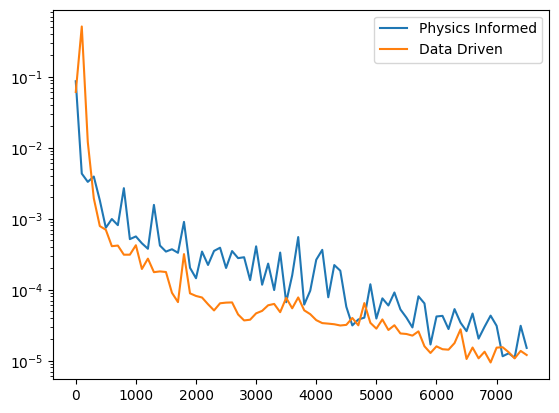

In [ ]:
x = np.linspace(0,7500,76)

plt.plot(x,PINO_acc_list,label = 'Physics Informed')
plt.plot(x,acc_list,label = 'Data Driven')
plt.yscale('log')
plt.legend();

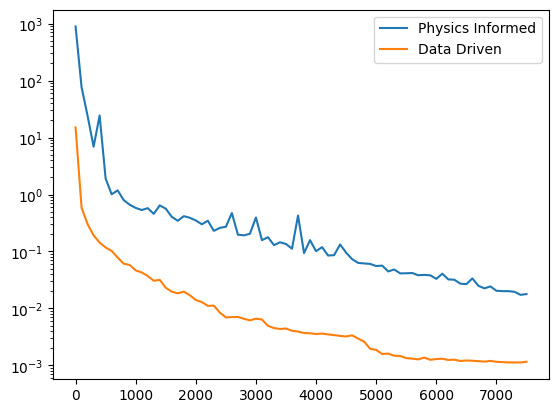

In [ ]:
x = np.linspace(0,7500,76)

plt.plot(x,PINO_loss_list,label = 'Physics Informed')
plt.plot(x,loss_list,label = 'Data Driven')
plt.yscale('log')
plt.legend();